<a href="https://colab.research.google.com/github/Nsethi16/Q-A_For_Enterprises/blob/main/Intelligent_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intelligent QA for Enterprise**

`
---

Retrieval-augmented generation (RAG) improves large language models (LLMs) by using external knowledge for accurate and up-to-date information. It addresses LLM inconsistencies and boosts response quality by grounding the model in external sources. This implementation ensures access to reliable facts and transparency for users to verify and trust the model's claims.

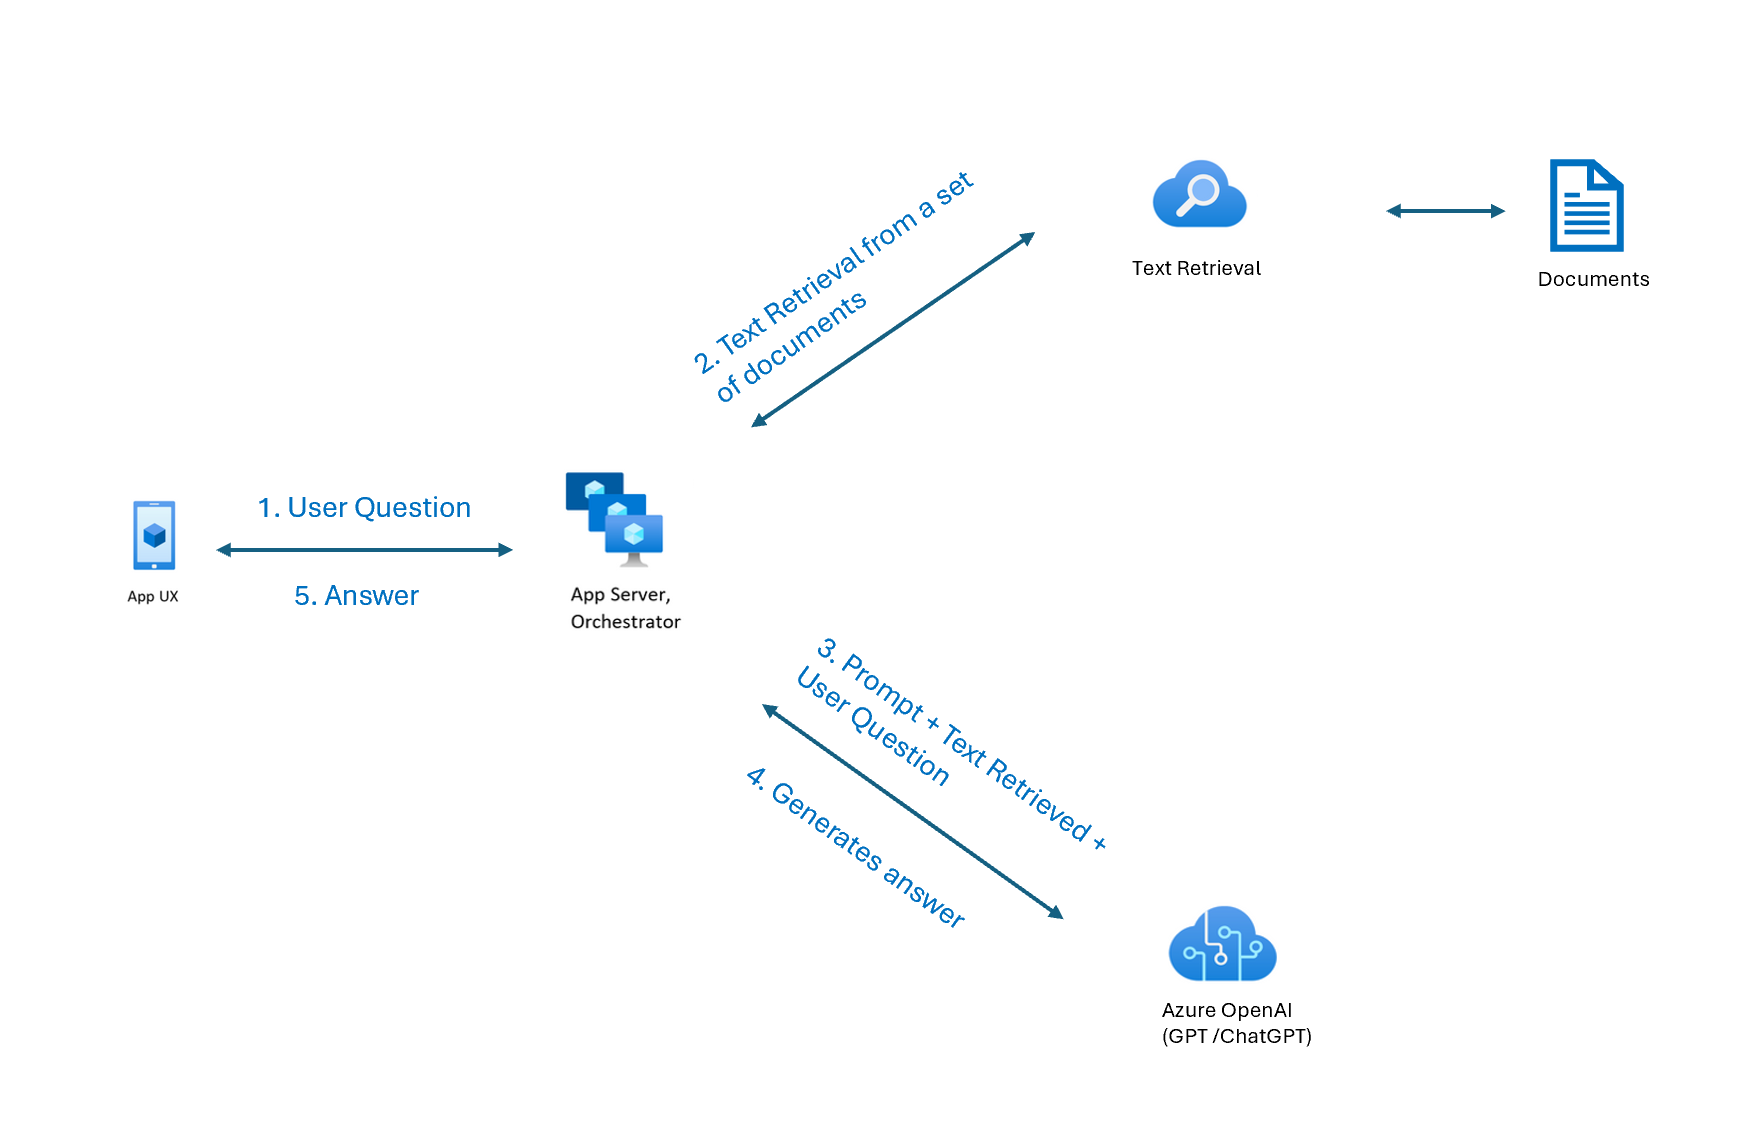

In this notebook, we'll follow these simple steps to implement RAG:

1. Make a small local text dataset about insurance policies offered by the enterprise. The goal is to answer user questions using the RAG Framework based on this dataset.

2. Use the OpenAI API to create embeddings for the text dataset. Develop a search function that finds relevant text for a user's question. This step is called Text Retrieval in RAG.

3. Concatenate the system prompt (instructions), the retrieved text, and the user's question. Utilize the OpenAI Chat Completion API to provide answers to user questions.

4. Evaluate the application using OpenAI as LLM on a Golden dataset of set of questions and benchmark answers.

Instructions: Update the OpenAI API Key in 3rd Code cell from https://platform.openai.com/api-keys before using this Notebook



Install the required packages

---



In [ ]:
!pip install openai==0.28.0
!pip install num2words

Import the packages

---



In [15]:
import openai
from num2words import num2words
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
from transformers import GPT2TokenizerFast
from IPython.display import Markdown, display

In [16]:
openai.api_key = "Update OpenAI Key here"

Step 1: Make a small local text dataset about insurance policies offered by the enterprise. The goal is to answer user questions using the RAG Framework based on this dataset.

---

In [17]:
content_01 = \
"Northwind Health Plus is a comprehensive plan that provides comprehensive coverage for medical, "\
"vision, and dental services. This plan also offers prescription drug coverage, mental health and"\
" substance abuse coverage, and coverage for preventive care services. With Northwind Health Plus,"\
" you can choose from a variety of in-network providers, including primary care physicians, "\
"specialists, hospitals, and pharmacies. This plan also offers coverage for emergency services,"\
" both in-network and out-of-network."


In [18]:
content_02 = \
"Northwind Standard is a basic plan that provides coverage for medical, vision, and dental services. "\
 "This plan also offers coverage for preventive care services, as well as prescription drug coverage."\
 "With Northwind Standard, you can choose from a variety of in-network providers, including primary  "\
 "care physicians, specialists, hospitals, and pharmacies. This plan does not offer coverage for     "\
 "emergency services, mental health and substance abuse coverage, or out-of-network services."

In [19]:
content_03 = \
"Northwind Health Plus offers more comprehensive coverage than Northwind Standard. This plan offers "\
"coverage for emergency services, both in-network and out-of-network, as well as mental health and  "\
"substance abuse coverage. Northwind Standard does not offer coverage for emergency services, mental"\
" health and substance abuse coverage, or out-of-network services. Both plans offer coverage for    "\
"prescription drugs. Northwind Health Plus offers a wider range of prescription drug coverage than  "\
"Northwind Standard. Northwind Health Plus covers generic, brandname, and specialty drugs, while  "\
"Northwind Standard only covers generic and brand-name drugs.  Both plans offer coverage for vision "\
"and dental services. Northwind Health Plus offers coverage for vision exams, glasses, and contact  "\
"lenses, as well as dental exams, cleanings, and fillings. Northwind Standard only offers coverage  "\
"for vision exams and glasses. Both plans offer coverage for medical services. Northwind Health Plus"\
"offers coverage for hospital stays, doctor visits, lab tests, and X-rays. Northwind Standard only  "\
"offers coverage for doctor visits and lab tests. Northwind Health Plus is a comprehensive plan that"\
" offers more coverage than Northwind Standard. Northwind Health Plus offers coverage for emergency "\
"services, mental health and substance abuse coverage, and out-of-network services, while Northwind "\
"Standard does not. Northwind Health Plus also offers a wider range of prescription drug coverage   "\
"than Northwind Standard. Both plans offer coverage for vision and dental services, as well as      "\
"medical services."

In [20]:
content_04 = \
"Contoso Electronics deducts the employee's portion of the healthcare cost from each paycheck. This "\
"means that the cost of the health insurance will be spread out over the course of the year, rather "\
"than being paid in one lump sum. The employee's portion of the cost will be calculated based on the"\
" selected health plan and the number of people covered by the insurance. The table below shows a   "\
"cost comparison between the different health plans offered by Contoso Electronics: Northwind "\
"standard 45.00 and Northwind Health Plus 55.00"

In [21]:
content_05 = \
"Introducing PerksPlus - the ultimate benefits program designed to support the health and wellness of "\
"employees. With PerksPlus, employees have the opportunity to expense up to $1000 for fitness-related "\
"programs, making it easier and more affordable to maintain a healthy lifestyle. PerksPlus is not only "\
"designed to support employees' physical health, but also their mental health. Regular exercise has been "\
"shown to reduce stress, improve mood, and enhance overall well-being. With PerksPlus, employees can "\
"invest in their health and wellness, while enjoying the peace of mind that comes with knowing they are "\
"getting the support they need to lead a healthy life."

In [22]:
content_06 = \
"PerksPlus covers a wide range of fitness activities, including but not limited to "\
"Gym memberships, Personal training sessions, Yoga and Pilates classes, Fitness equipment purchases, "\
"Sports team fees, Health retreats and spas, Outdoor adventure activities "\
"(such as rock climbing, hiking, and kayaking), Group fitness classes "\
"(such as dance, martial arts, and cycling), Virtual fitness programs "\
"(such as online yoga and workout classes). "

In [23]:
# Create local Text dataset about the insurance policies
knowledge_base = [
    {
        "title"     : "Northwind Health Plus",
        "content"   : content_01
    },
    {
        "title"     : "Northwind Standard",
        "content"   : content_02
    },
    {
        "title"     : "plan comparison of Northwind Health Plus and Northwind Standard",
        "content"   : content_03
    },
    {
        "title"     : "cost comparison of Northwind Health Plus and Northwind Standard",
        "content"   : content_04
    },
    {
        "title"     : "PerksPlus Information",
        "content"   : content_05
    },
    {
        "title"     : "PerksPlus Coverage",
        "content"   : content_06
    }
]

# Convert it into panda dataframe
df = pd.DataFrame(knowledge_base)

# Combine the different columns from dataset into a new column called "combined"
# Text retrieval is developed on this new column so that retrieval happens at both Title and Content
df["combined"] = ( "Title: " + df.title.str.strip() + "; Content: " + df.content.str.strip())

In [24]:
# Display each item in knowledge_base using Markdown
for item in knowledge_base:
    display(Markdown(f"**Title:** {item['title']}  \n**Content:** {item['content']}  \n"))

**Title:** Northwind Health Plus  
**Content:** Northwind Health Plus is a comprehensive plan that provides comprehensive coverage for medical, vision, and dental services. This plan also offers prescription drug coverage, mental health and substance abuse coverage, and coverage for preventive care services. With Northwind Health Plus, you can choose from a variety of in-network providers, including primary care physicians, specialists, hospitals, and pharmacies. This plan also offers coverage for emergency services, both in-network and out-of-network.  


**Title:** Northwind Standard  
**Content:** Northwind Standard is a basic plan that provides coverage for medical, vision, and dental services. This plan also offers coverage for preventive care services, as well as prescription drug coverage.With Northwind Standard, you can choose from a variety of in-network providers, including primary  care physicians, specialists, hospitals, and pharmacies. This plan does not offer coverage for     emergency services, mental health and substance abuse coverage, or out-of-network services.  


**Title:** plan comparison of Northwind Health Plus and Northwind Standard  
**Content:** Northwind Health Plus offers more comprehensive coverage than Northwind Standard. This plan offers coverage for emergency services, both in-network and out-of-network, as well as mental health and  substance abuse coverage. Northwind Standard does not offer coverage for emergency services, mental health and substance abuse coverage, or out-of-network services. Both plans offer coverage for    prescription drugs. Northwind Health Plus offers a wider range of prescription drug coverage than  Northwind Standard. Northwind Health Plus covers generic, brandname, and specialty drugs, while  Northwind Standard only covers generic and brand-name drugs.  Both plans offer coverage for vision and dental services. Northwind Health Plus offers coverage for vision exams, glasses, and contact  lenses, as well as dental exams, cleanings, and fillings. Northwind Standard only offers coverage  for vision exams and glasses. Both plans offer coverage for medical services. Northwind Health Plusoffers coverage for hospital stays, doctor visits, lab tests, and X-rays. Northwind Standard only  offers coverage for doctor visits and lab tests. Northwind Health Plus is a comprehensive plan that offers more coverage than Northwind Standard. Northwind Health Plus offers coverage for emergency services, mental health and substance abuse coverage, and out-of-network services, while Northwind Standard does not. Northwind Health Plus also offers a wider range of prescription drug coverage   than Northwind Standard. Both plans offer coverage for vision and dental services, as well as      medical services.  


**Title:** cost comparison of Northwind Health Plus and Northwind Standard  
**Content:** Contoso Electronics deducts the employee's portion of the healthcare cost from each paycheck. This means that the cost of the health insurance will be spread out over the course of the year, rather than being paid in one lump sum. The employee's portion of the cost will be calculated based on the selected health plan and the number of people covered by the insurance. The table below shows a   cost comparison between the different health plans offered by Contoso Electronics: Northwind standard 45.00 and Northwind Health Plus 55.00  


**Title:** PerksPlus Information  
**Content:** Introducing PerksPlus - the ultimate benefits program designed to support the health and wellness of employees. With PerksPlus, employees have the opportunity to expense up to $1000 for fitness-related programs, making it easier and more affordable to maintain a healthy lifestyle. PerksPlus is not only designed to support employees' physical health, but also their mental health. Regular exercise has been shown to reduce stress, improve mood, and enhance overall well-being. With PerksPlus, employees can invest in their health and wellness, while enjoying the peace of mind that comes with knowing they are getting the support they need to lead a healthy life.  


**Title:** PerksPlus Coverage  
**Content:** PerksPlus covers a wide range of fitness activities, including but not limited to Gym memberships, Personal training sessions, Yoga and Pilates classes, Fitness equipment purchases, Sports team fees, Health retreats and spas, Outdoor adventure activities (such as rock climbing, hiking, and kayaking), Group fitness classes (such as dance, martial arts, and cycling), Virtual fitness programs (such as online yoga and workout classes).   


Step 2: Use the OpenAI API to create embeddings for the text dataset. Develop a search function that finds relevant text for a user's question. This step is called Text Retrieval in RAG.

---



In [25]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [26]:
# Generate Embeddings and add to a new column "embeddings" in panda dataframe
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

In [27]:
# search through the policies for user's query
def search_policy(df, user_query, n=3):
    text_to_return = ""
    user_query_embedding = get_embedding(
        user_query,
        engine=embedding_model
        # model="text-embedding-ada-002"
    )
    # perform the search
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, user_query_embedding))

# top n results
    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
# Concatenate the results
    for r in results:
      text_to_return = text_to_return + r
    return text_to_return

In [28]:
# Test the Search Policy Function
results = search_policy(df, "compare Cost of Northwind Health Plus and Northwind Standard", n=2)

In [29]:
print(results)

plan comparison of Northwind Health Plus and Northwind Standard:  Northwind Health Plus offers more comprehensive coverage than Northwind Standard. This plan offers coverage for emergency services, both in-network and out-of-network, as well as mental health and  substance abuse coverage. Northwind Standard does not offer coverage for emergency services, mental health and substance abuse coverage, or out-of-network services. Both plans offer coverage for    prescription drugs. Northwind Health Plus offers a wider range of prescription drug coverage than  Northwind Standard. Northwind Health Plus covers generic, brandname, and specialty drugs, while  Northwind Standard only covers generic and brand-name drugs.  Both plans offer coverage for vision and dental services. Northwind Health Plus offers coverage for vision exams, glasses, and contact  lenses, as well as dental exams, cleanings, and fillings. Northwind Standard only offers coverage  for vision exams and glasses. Both plans offe

Step 3: Concatenate the system prompt (instructions), the retrieved text, and the user's question. Utilize the OpenAI Chat Completion API to provide answers to user questions.

In [30]:
# Define the System prompt (Instructions to OpenAI Chat Completion)
system_message_chat_conversation = \
"You are an assistant designed for accurate and respectful responses to user queries"\
" about insurance policies with no prior knowlwdge to answer question. You must "\
"always use the text followed after context: as ground truth and If there isn't "\
"enough information, just say you don't know and do not provide any more "\
"information/answer."

In [31]:
# Define the Main Function which takes the user's question, Calls the
# search_policy Function for Text Retrieval for user's question and
# then calls the OpenAI Chat Completion API to answer User's question

def main(user_question: str) -> str:
  # Text Retrieval step for User's Question
  results = search_policy(df, user_question, n=2)

  # Create System Message + retrieved text as context
  concatenated_result = (
    system_message_chat_conversation +
    " context:" +
    str(results)
  )

  # Create the chat messages for OpenAI API
  messages = [{"role": "system", "content": concatenated_result}]
  messages.append({"role": "user", "content": user_question})

  # Call the OpenAI API to get the answer for User's question
  chat_completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages)

  return chat_completion.choices[0].message.content


In [32]:
# Test the application for a single question
answer = main("Compare Cost of Northwind Health Plus and Northwind Standard")
print(answer)

The cost comparison between Northwind Health Plus and Northwind Standard is as follows: 

- The employee's portion of the healthcare cost for Northwind Standard is $45.00.
- The employee's portion of the healthcare cost for Northwind Health Plus is $55.00.

So, the cost of Northwind Health Plus is higher than Northwind Standard by $10.00.


Step 4: Evaluate the application using OpenAI as LLM on a Golden dataset of set of questions and benchmark answers.

In [33]:
# Define the System prompt (Instructions to OpenAI Chat Completion)
system_message_eval_conversation = \
"You are an assistant designed to compare the benchmark_answer and generated_answer on how similiar they are to each other "\
"and give it a score b/w 1 to 5 where 1 means least similiar and 5 means most similair. Your response must always be just "\
" a number between 1 and 5 based on this comparison and nothing else in the respone."

In [34]:
# Create Golden Dataset for evaluation
# Please note last question and corresponding benchmark answer (not really a benchmark answer) is
# added to prove that evaluation works and we'll see a low score for this question, which will lower
# the average score as well
# Again, this is to prove that evaluation is working
evaluation_dataset = [
    {
        "question"           : "Compare Cost of Northwind Health Plus and Northwind Standard?",
        "benchmark_answer"   : "The cost of Northwind Health Plus is $55.00 and the cost of Northwind Standard is $45.00."
    },
    {
        "question"           : "What all is covered in PerksPlus?",
        "benchmark_answer"   : "PerksPlus offers a variety of fitness activities, like gym memberships, personal training, yoga and Pilates classes, fitness equipment, sports team fees, health retreats, outdoor adventures (rock climbing, hiking, kayaking), group fitness (dance, martial arts, cycling), and virtual programs (online yoga and workouts)."
    },
    {
        "question"           : "Tell me about PerksPlus plan?",
        "benchmark_answer"   : "PerksPlus is a Music Subscription"
    }
]

In [37]:
# Evaluation
scores = []
# Loop through Golden Dataset and evaluate each generated answer and benchmark answer
# and Finally give average score b/w 1 - 5 where 1 means the worst peformance and
# 5 means the best performance
for data_point in evaluation_dataset:
    question = data_point["question"]
    # Call the application for generated answer
    generated_answer = main(question)

    benchmark_answer = data_point['benchmark_answer']
    evaluation_instruction = ""

    # Create instructions for Evaluation for LLM Calls
    evaluation_instruction = (
        system_message_eval_conversation +
        " benchmark_answer: " +
        str(benchmark_answer) +
        " generated_answer: " +
        str(generated_answer)
      )

    # Create the chat messages for OpenAI API
    messages = [{"role": "system", "content": evaluation_instruction}]
    messages.append({"role": "user", "content": "Give the comparison a score"})

      # Call the OpenAI API to get the evaluation score
    chat_completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages)

    messages.clear()
    # Get the score for current call
    eval_score = chat_completion.choices[0].message.content
    scores.append(int(eval_score))
    data_point["generated_answer"] = generated_answer
    data_point["evaluation_score"] = int(eval_score)

# Calculate the Average score across
average_score = sum(scores) / len(scores) if len(scores) > 0 else 0

print(f"Average Score: {average_score}")
print("Here is Golden Evaluation Dataset with updated generated_answer and corresponding evaluation_score")
# print(evaluation_dataset)
for data_point in evaluation_dataset:
    display(Markdown(f"**Question:** {data_point['question']}  \n**Benchmark Answer:** {data_point['benchmark_answer']}  \n**Generated Answer:** {data_point['generated_answer']}  \n**Evaluation Score:** {data_point['evaluation_score']} \n"))

Average Score: 4.0
Here is Golden Evaluation Dataset with updated generated_answer and corresponding evaluation_score


**Question:** Compare Cost of Northwind Health Plus and Northwind Standard?  
**Benchmark Answer:** The cost of Northwind Health Plus is $55.00 and the cost of Northwind Standard is $45.00.  
**Generated Answer:** The cost comparison between Northwind Health Plus and Northwind Standard is as follows: Northwind Standard costs $45.00 and Northwind Health Plus costs $55.00.  
**Evaluation Score:** 5 


**Question:** What all is covered in PerksPlus?  
**Benchmark Answer:** PerksPlus offers a variety of fitness activities, like gym memberships, personal training, yoga and Pilates classes, fitness equipment, sports team fees, health retreats, outdoor adventures (rock climbing, hiking, kayaking), group fitness (dance, martial arts, cycling), and virtual programs (online yoga and workouts).  
**Generated Answer:** PerksPlus covers a wide range of fitness activities, including but not limited to:
1. Gym memberships
2. Personal training sessions
3. Yoga and Pilates classes
4. Fitness equipment purchases
5. Sports team fees
6. Health retreats and spas
7. Outdoor adventure activities (such as rock climbing, hiking, and kayaking)
8. Group fitness classes (such as dance, martial arts, and cycling)
9. Virtual fitness programs (such as online yoga and workout classes).

Please note that this information is based on the provided context.  
**Evaluation Score:** 5 


**Question:** Tell me about PerksPlus plan?  
**Benchmark Answer:** PerksPlus is a Music Subscription  
**Generated Answer:** PerksPlus is a benefits program designed to support the health and wellness of employees. It allows employees to expense up to $1000 for fitness-related programs, making it more accessible and affordable to maintain a healthy lifestyle. This program not only focuses on physical health but also mental health. Regular exercise has been proven to reduce stress, improve mood, and enhance overall well-being. With PerksPlus, employees can invest in their health and wellness while having peace of mind knowing they have the support they need. The program covers a wide range of fitness activities, including gym memberships, personal training sessions, yoga and pilates classes, fitness equipment purchases, sports team fees, health retreats and spas, outdoor adventure activities such as rock climbing, hiking, and kayaking, group fitness classes such as dance, martial arts, and cycling, as well as virtual fitness programs like online yoga and workout classes.  
**Evaluation Score:** 2 
